# **Visual EEG Pattern Synthesis and Recognition with Deep Learning**

### Loading the Data

In [ ]:
import numpy as np

In [ ]:
dataset = np.load('/content/drive/MyDrive/1.npy')

In [ ]:
dataset

array([[-16, -29,   2, ..., -11,  15,   0],
       [-56, -54, -27, ...,   1,  21,   0],
       [-55, -55, -29, ...,  18,  35,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   9],
       [  0,   0,   0, ...,   0,   0,   9],
       [  0,   0,   0, ...,   0,   0,   9]])

In [ ]:
dataset.shape

(259520, 65)

In [ ]:
dataset = dataset[dataset[:,-1]!=10,:]

### Data Segmentation

In [ ]:
def extract(input, n_classes, n_fea, time_window, moving):
    xx = input[:, :n_fea]
    yy = input[:, n_fea:n_fea + 1]
    new_x = []
    new_y = []
    number = int((xx.shape[0] / moving) - 1)
    for i in range(number):
        ave_y = np.average(yy[int(i * moving):int(i * moving + time_window)])
        if ave_y in range(n_classes + 1):
            new_x.append(xx[int(i * moving):int(i * moving + time_window), :])
            new_y.append(ave_y)

    new_x = np.array(new_x)
    new_x = new_x.reshape([-1, n_fea * time_window])
    new_y = np.array(new_y)
    new_y.shape = [new_y.shape[0], 1]
    data = np.hstack((new_x, new_y))
    data = np.vstack((data, data[-1]))  # add the last sample again, to make the sample number round
    return data

In [ ]:
data = extract(dataset ,10 ,64 ,16 ,8)

### Divide data into training and testing

In [ ]:
from sklearn.model_selection import train_test_split
n_fea = 64
time_window = 16
no_longfeature = n_fea * time_window
data_seg_feature = data[:, :no_longfeature]
data_seg_label = data[:, no_longfeature:no_longfeature+1]
train_feature, test_feature, train_label, test_label = train_test_split(data_seg_feature, data_seg_label,test_size=0.2, shuffle=True)

In [ ]:
train_feature.shape

(13754, 1024)

In [ ]:
test_feature.shape

(3439, 1024)

### Data Preprocessing

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler1 = StandardScaler().fit(train_feature)
train_fea_norm1 = scaler1.transform(train_feature) # normalize the training data
test_fea_norm1 = scaler1.transform(test_feature) # normalize the test data

### Building a CNN Network

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=(2,4),
                stride=1,
                padding= (1,2)  #([1,2]-1)/2,
            ),
            nn.ReLU(),
            nn.MaxPool2d((2,4))
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, (2,2), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2))
        )


        self.fc = nn.Linear(1024, 128)  # 64*2*4
        self.out = nn.Linear(128, n_class)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc(x))
        x = F.dropout(x, p=0.2)
        output = self.out(x)
        return output

In [ ]:
BATCH_size = 100
n_class = 10

In [ ]:
n_class=10
cnn = CNN()
# let's pass an input to it
input = torch.randn(BATCH_size, 1, 16, 64)
output = cnn(input)

### Train the CNN Network

In [ ]:
cnn = CNN()
# lets test out network by passing noise to it  as input
import time
start_time = time.perf_counter()




device = "cuda" if torch.cuda.is_available() else "cpu"
cnn.to(device)
LR = 0.001
l2 = 0.001
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR, weight_decay=l2)
loss_func = nn.CrossEntropyLoss()

In [ ]:
segment_length = 16
no_feature = 64

train_fea_norm1 = train_fea_norm1.reshape([-1, segment_length, no_feature])
test_fea_norm1 = test_fea_norm1.reshape([-1, segment_length, no_feature])

In [ ]:
train_label.shape

(13754, 1)

In [ ]:
BATCH_size = 10000

In [ ]:
import torch.utils.data as Data

# feed data into dataloader
train_fea_norm1 = torch.tensor(train_fea_norm1)
train_fea_norm1 = torch.unsqueeze(train_fea_norm1, dim=1).type('torch.FloatTensor').to(device)

train_label = torch.tensor(train_label.flatten()).to(device)
train_data = Data.TensorDataset(train_fea_norm1, train_label)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_size, shuffle=True)

test_fea_norm1 = torch.tensor(test_fea_norm1)
test_fea_norm1 = torch.unsqueeze(test_fea_norm1, dim=1).type('torch.FloatTensor').to(device)
test_label = torch.tensor(test_label.flatten()).to(device)

In [ ]:
# training and testing
for epoch in range(300):
    for step, (train_x, train_y) in enumerate(train_loader):
        output = cnn(train_x)  # CNN output of training data
        loss = loss_func(output, train_y.long())  # cross entropy loss
        optimizer.zero_grad()  # clear gradients for this training step
        loss.backward()  # backpropagation, compute gradients
        optimizer.step()  # apply gradients

    if epoch % 10 == 0:
        test_output = cnn(test_fea_norm1)  # CNN output of test data
        test_loss = loss_func(test_output, test_label.long())

        print(test_loss.item())

2.287122964859009
2.1805789470672607
2.09138822555542
2.0384068489074707
1.996659517288208
1.9679419994354248
1.934112548828125
1.8920750617980957
1.869688868522644
1.8449182510375977
1.8213329315185547
1.8042495250701904
1.7858295440673828
1.7524794340133667
1.735917091369629
1.7098644971847534
1.6991472244262695
1.6921261548995972
1.6600852012634277
1.6573256254196167
1.6268863677978516
1.607944369316101
1.6024243831634521
1.583615779876709
1.5597617626190186
1.5331387519836426
1.5217981338500977
1.5404363870620728
1.4975922107696533
1.4952970743179321


Confusion Matrix:
[[115   1   9  15  28  11   8  16  11  22]
 [  5 199   6   6   5   3   2   2   7   4]
 [ 27   5 121  92  18  26  40  25  20  13]
 [ 23   6  40 175   5  14  42  17  20  10]
 [ 38   4   9  13 184  54  22  17  20  25]
 [ 31   3  11  18  77 134  26  22  19  27]
 [ 13   1  11  25  10  11 203  53  35  26]
 [ 11   1   9  27  15  10  55 175  13  31]
 [ 10  12   8  17  23  20  51  27 131  55]
 [ 14  12  10  13  26  26  42  25  52 162]]


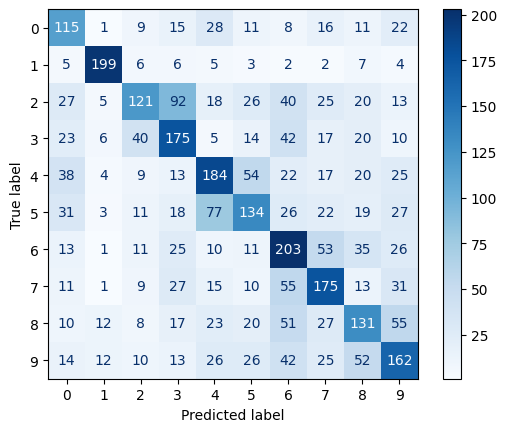

In [ ]:
from sklearn.metrics import  confusion_matrix ,ConfusionMatrixDisplay

true_y = test_label.data.cpu().numpy()
pred_y = torch.max(test_output, 1)[1].data.cpu().numpy()

# Create confusion matrix
conf_matrix = confusion_matrix(true_y, pred_y)
print("Confusion Matrix:")
print(conf_matrix)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues')

### Loading Data

In [ ]:
import scipy.io as sc
import numpy as np
from sklearn import preprocessing

data = np.load(open('/content/drive/MyDrive/all_01.dat', 'rb'),allow_pickle=True)


In [ ]:
data.shape

(3200, 2380)

### Data Preprocessing

In [ ]:
EEG = preprocessing.minmax_scale(data[:, :140], axis=1)
EEG = EEG * 2 -1
ima = preprocessing.minmax_scale(data[:, 140:], axis=1)
ima = ima * 2 - 1
data = np.hstack((EEG, ima))

ima_size = 40 * 56
noise_size = 140


In [ ]:
# Label creation
l0 = np.zeros([int(3200/5), 1])
for lab in range(1, 5):
    l_ = np.ones([int(3200/5), 1]) * lab
    l0 = np.vstack((l0, l_))

In [ ]:
# Concatenate with the label and shuffle
data = np.hstack((data, l0))
np.random.shuffle(data)

### Building a CNN Network for Feature Extraction

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding="same")
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding="same")
        self.fc1 = nn.Linear(64 * 2 * 3, 40) # Adjust based on the input dimensions after pooling
        self.fc2 = nn.Linear(40, 5) # Number of classes is 5

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 2 * 3) # Adjust based on the input dimensions after pooling
        x = F.dropout(x, 0.5)
        x1 = torch.sigmoid(self.fc1(x))
        x2 = self.fc2(x1)
        return x2 , x1

In [ ]:
# Parameters and settings
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [ ]:
n_class = 5
label = data[:,-1]
feature = data[:, :140]

In [ ]:
data_original = data

In [ ]:
n_group = 5
batch_size = int(label.shape[0]/n_group)

In [ ]:
label.shape

(3200,)

In [ ]:
train_fea = []

for i in range(n_group):
    f = feature[int(0+batch_size*i):int(batch_size+batch_size*i)]
    train_fea.append(f)

train_label = []
for i in range(n_group):
    f = label[int(0 + batch_size * i):int(batch_size + batch_size * i)]
    train_label.append(f)

test_fea = torch.tensor(train_fea[-1], dtype=torch.float32)
test_label = torch.tensor(train_label[-1], dtype=torch.long)

train_data = [(torch.tensor(train_fea[i], dtype=torch.float32), torch.tensor(train_label[i], dtype=torch.long)) for i in range(n_group-1)]


In [ ]:
def compute_accuracy(pred, target):
    _, predicted = torch.max(pred.data, 1)
    total = target.size(0)
    correct = (predicted == target).sum().item()
    return correct / total

In [ ]:
epochs = 1000
for epoch in range(epochs):
    model.train()
    for i, data in enumerate(train_data):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.view(-1, 1, 10, 14)

        optimizer.zero_grad()
        outputs ,_  = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    if epoch % 100 == 0:
        model.eval()
        with torch.no_grad():
            inputs = test_fea.view(-1, 1, 10, 14).to(device)
            outputs,_ = model(inputs)
            test_loss = criterion(outputs, test_label.to(device))
            test_acc = compute_accuracy(outputs, test_label.to(device))

            print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item()}, Test Loss: {test_loss.item()}, Test Accuracy: {test_acc}')

        if test_acc > 0.6:
            break

Epoch [0/1000], Loss: 1.6470043659210205, Test Loss: 1.638946533203125, Test Accuracy: 0.1875
Epoch [100/1000], Loss: 1.2469686269760132, Test Loss: 1.3755550384521484, Test Accuracy: 0.4046875
Epoch [200/1000], Loss: 1.0165400505065918, Test Loss: 1.1861259937286377, Test Accuracy: 0.50625
Epoch [300/1000], Loss: 0.8627511262893677, Test Loss: 1.151057481765747, Test Accuracy: 0.5484375
Epoch [400/1000], Loss: 0.739446222782135, Test Loss: 1.1003509759902954, Test Accuracy: 0.5671875
Epoch [500/1000], Loss: 0.6901469826698303, Test Loss: 1.0733649730682373, Test Accuracy: 0.6015625


In [ ]:
# Extract features
import pickle
model.eval()
with torch.no_grad():
    EEG_train_features_from_cnn = model(torch.tensor(train_fea,dtype=torch.float32).view(-1, 1, 10, 14).to(device))[1].cpu().numpy()
    all_new_data = np.hstack((EEG_train_features_from_cnn, data_original[:, 140:]))

    pickle.dump(all_new_data, open('EEG_feature.pkl', 'wb'))
print('dumped as shape_EEG_feature.pkl', data_original.shape, all_new_data.shape)

dumped as shape_EEG_feature.pkl (3200, 2381) (3200, 2281)


<ipython-input-38-0d0e4a0730a0>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  EEG_train_features_from_cnn = model(torch.tensor(train_fea,dtype=torch.float32).view(-1, 1, 10, 14).to(device))[1].cpu().numpy()


### Building Generator Network

In [ ]:
class Generator(nn.Module):
    def __init__(self, noise_dim, n_class):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(noise_dim, 140 * 64)
        self.bn1 = nn.BatchNorm1d(140 * 64, momentum=0.9)
        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2, padding=2, output_padding=1)
        #Hout​=(Hin​−1)×stride−2×padding+kernel_size+output_padding # 20
        #𝑊𝑜𝑢𝑡=(𝑊𝑖𝑛−1)×stride−2×padding+kernel_size+output_padding  # 28
        self.bn2 = nn.BatchNorm2d(32, momentum=0.9)
        self.deconv2 = nn.ConvTranspose2d(32, 1, kernel_size=5, stride=2, padding=2, output_padding=1)
        #Hout​=(Hin​−1)×stride−2×padding+kernel_size+output_padding # 40
        #𝑊𝑜𝑢𝑡=(𝑊𝑖𝑛−1)×stride−2×padding+kernel_size+output_padding  # 56
        self.fc2 = nn.Linear(40 * 56, 20 * 20)
        self.fc3 = nn.Linear(20 * 20, n_class)


    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = x.view(-1, 64, 10, 14)  # Reshape to match TensorFlow's behavior
        x = F.relu(self.bn2(self.deconv1(x)))
        x = self.deconv2(x)
        logits = x.view(-1, 40 * 56)  # Flatten
        outputs = torch.tanh(logits)
        mid = torch.sigmoid(self.fc2(logits))
        pred = self.fc3(mid)
        return logits, outputs, pred

# Example usage
noise_dim = 60
n_class = 5

generator = Generator(noise_dim, n_class)
noise_img = torch.randn((64, noise_dim))  # batch_size of 64
logits, outputs, pred = generator(noise_img)

print(logits.shape)  # Expected shape: [64, 40 * 56]


torch.Size([64, 2240])


### Building Discriminator Network

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, n_class):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding="same")
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64* 20* 28 + 40, 1)
        self.fc2 = nn.Linear(64* 20* 28 + 40, n_class)

    def forward(self, x, cond):
        x = x.view(-1, 1, 40, 56)
        x = F.leaky_relu(self.bn1(self.conv1(x)), 0.2)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2)
        x = x.view(-1, 64* 20* 28)
        x = torch.cat((x, cond[: ,20:]), 1)

        logits = self.fc1(x)
        outputs_2 = self.fc2(x)
        return logits, logits, outputs_2

# Example usage
noise_size = 60
n_class = 5

discriminator = Discriminator(n_class)
img = torch.randn((64, 40 * 56))  # batch_size of 64
noise = torch.randn((64, noise_size))  # batch_size of 64
logits, outputs, outputs_2 = discriminator(img, noise)


In [ ]:
# Example usage
noise_size = 60
n_class = 5

discriminator = Discriminator(n_class)
img = torch.randn((64, 40 * 56))  # batch_size of 64
noise = torch.randn((64, noise_size))  # batch_size of 64
logits, outputs, outputs_2 = discriminator(img, noise)

In [ ]:
outputs.shape

torch.Size([64, 1])

In [ ]:
outputs_2.shape

torch.Size([64, 5])

### Training and Testing the Generative Adversarial Network (GAN) NN

In [ ]:
data = pickle.load(open('/content/EEG_feature.pkl', 'rb'))
label = data[:, -1]
data = data[:, :-1]
data = torch.tensor(data, dtype=torch.float32)
label = torch.tensor(label, dtype=torch.long)

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image

img_size = 40 * 56
noise_size = 60
n_class = 5
batch_size = 80
epochs = 1000
smooth = 0.1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Prepare DataLoader
dataset = TensorDataset(data[:, 40:], data[:, :40], label)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize models
generator = Generator(noise_size, n_class).to(device)
discriminator = Discriminator(n_class).to(device)

# Optimizers
learning_rate = 0.0002
d_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
CrossEntropyLoss = nn.CrossEntropyLoss()
# Training loop
import tqdm.notebook as tqdm
for epoch in tqdm.tqdm(range(epochs)):
    for real_img, EEG, ground_truth in dataloader:

        batch_noise = torch.cat((torch.randn(batch_size, 20).to(device), EEG.to(device)), 1)

        # Train discriminator
        discriminator.zero_grad()
        d_logits_real, d_outputs_real, real_category_pred = discriminator(real_img.view(-1, 1, 40, 56).to(device), batch_noise.to(device))
        d_logits_fake, d_outputs_fake, fake_category_pred = discriminator(generator(batch_noise)[1].detach(), batch_noise.to(device))

        d_loss_real = F.binary_cross_entropy_with_logits(d_logits_real, torch.ones_like(d_logits_real).to(device) * (1 - smooth))
        d_loss_fake = F.binary_cross_entropy_with_logits(d_logits_fake, torch.zeros_like(d_logits_fake).to(device))
        d_loss_rf = d_loss_real + d_loss_fake

        d_loss_category_real = F.binary_cross_entropy_with_logits(real_category_pred, F.one_hot(ground_truth, num_classes=5).float().to(device))
        d_loss = d_loss_rf + d_loss_category_real

        d_loss.backward()
        d_optimizer.step()

        # Train generator
        for _ in range(2):
            g_optimizer.zero_grad()
            g_logits, g_outputs, pred = generator(batch_noise.to(device))
            d_logits_fake, d_outputs_fake, fake_category_pred = discriminator(g_outputs, batch_noise.to(device))

            g_loss = F.binary_cross_entropy_with_logits(d_logits_fake, torch.ones_like(d_logits_fake).to(device))

            d_loss_category_fake = F.binary_cross_entropy_with_logits(fake_category_pred , F.one_hot(ground_truth, num_classes=5).float().to(device))
            g_regular = F.mse_loss(g_outputs.view(-1,1), real_img.view(-1,1).to(device))
            g_loss = g_loss + 0.8 *d_loss_category_fake + g_regular

            g_loss.backward()
            g_optimizer.step()

    if epoch % 100 == 0 and epoch != 0:
        train_loss_d = d_loss.item()
        train_loss_d_rf = d_loss_rf.item()
        train_loss_g = g_loss.item()
        train_loss_c = d_loss_category_fake.item()
        acc = compute_accuracy(fake_category_pred, ground_truth.to(device))
        ic_fake = compute_accuracy(fake_category_pred, ground_truth.to(device))
        ic_real = compute_accuracy(real_category_pred,ground_truth.to(device))

        print(f"Epoch {epoch}/{epochs}, D Loss: {train_loss_d:.4f}(r/f: {train_loss_d_rf:.4f} , G Loss: {train_loss_g:.4f}, RMSE: { g_regular:.4f}, C loss {train_loss_c:.4f}, acc: {acc:.4f}, IC real: {ic_real:.4f}, IC fake: {ic_fake:.4f}")

        # Save generated images
        with torch.no_grad():
            gen_samples = generator(batch_noise.to(device))[1].view(-1, 40, 56).cpu().numpy()
            real_img = real_img.view(-1, 40, 56).cpu().numpy()

            for j in range(10):

                im = gen_samples[j]
                im = ((im + 1) * 127.5).astype(np.uint8)
                Image.fromarray(im, mode='L').save(f'/content/drive/MyDrive/generated_images/generated_{epoch}_{j}.jpg')

                rm = real_img[j]
                rm = ((rm + 1) * 127.5).astype(np.uint8)
                Image.fromarray(rm, mode='L').save(f'/content/drive/MyDrive/generated_images/real_{epoch}_{j}.jpg')

        print('Images saved')

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 100/1000, D Loss: 0.4963(r/f: 0.4963 , G Loss: 4.6231, RMSE: 0.1132, C loss 0.6599, acc: 0.7250, IC real: 1.0000, IC fake: 0.7250
Images saved
Epoch 200/1000, D Loss: 0.7836(r/f: 0.7836 , G Loss: 3.2074, RMSE: 0.1772, C loss 1.4945, acc: 0.5625, IC real: 1.0000, IC fake: 0.5625
Images saved
Epoch 300/1000, D Loss: 0.3688(r/f: 0.3688 , G Loss: 5.7473, RMSE: 0.1403, C loss 1.4832, acc: 0.6375, IC real: 1.0000, IC fake: 0.6375
Images saved
Epoch 400/1000, D Loss: 0.3325(r/f: 0.3325 , G Loss: 8.1849, RMSE: 0.2039, C loss 1.9396, acc: 0.5625, IC real: 1.0000, IC fake: 0.5625
Images saved
Epoch 500/1000, D Loss: 0.3602(r/f: 0.3602 , G Loss: 7.8457, RMSE: 0.1536, C loss 1.8364, acc: 0.6125, IC real: 1.0000, IC fake: 0.6125
Images saved
Epoch 600/1000, D Loss: 0.3521(r/f: 0.3521 , G Loss: 6.5190, RMSE: 0.1522, C loss 1.5917, acc: 0.6375, IC real: 1.0000, IC fake: 0.6375
Images saved
Epoch 700/1000, D Loss: 0.3339(r/f: 0.3339 , G Loss: 8.3669, RMSE: 0.1957, C loss 2.2762, acc: 0.5750, IC 

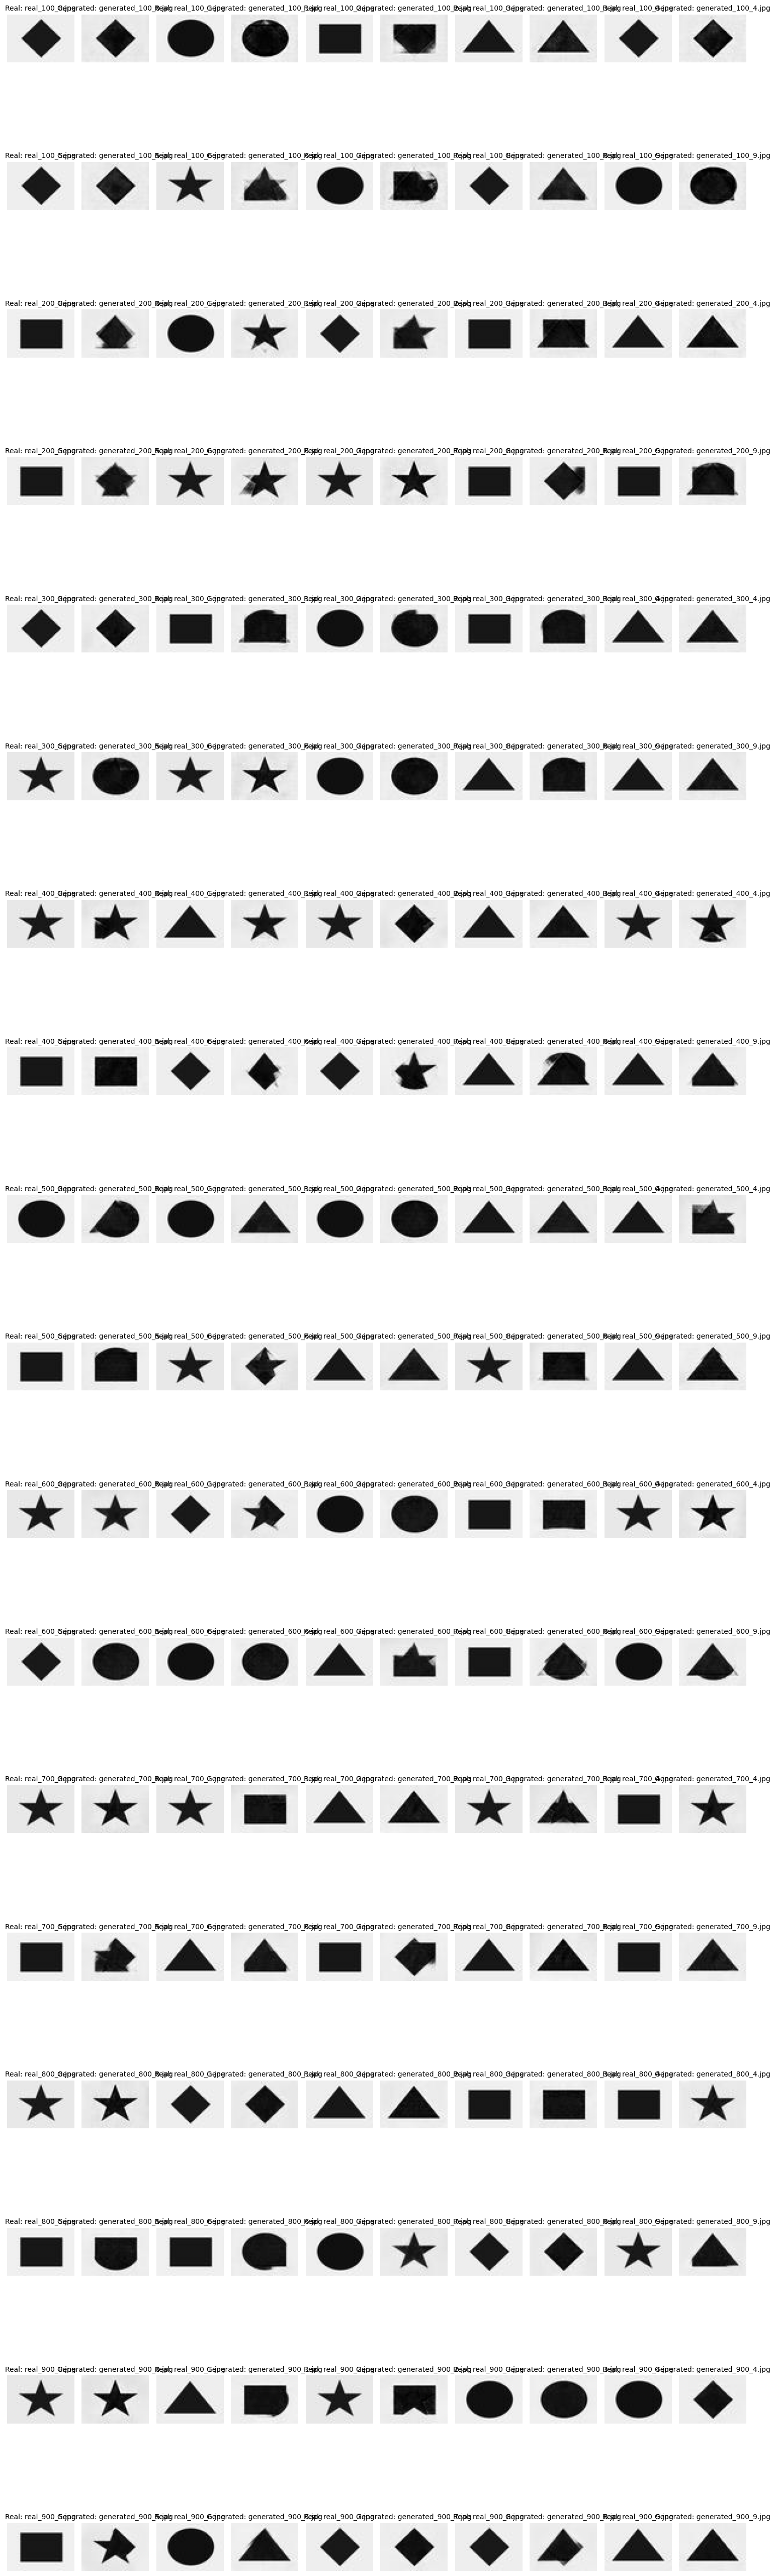

In [ ]:
import cv2
import matplotlib.pyplot as plt
import os

# Path to the generated images directory
images_path = '/content/drive/MyDrive/generated_images'

# Get the filenames of the real and generated images
real_images = sorted([f for f in os.listdir(images_path) if f.startswith('real_') and f.endswith('.jpg')])
gen_images = sorted([f for f in os.listdir(images_path) if f.startswith('generated_') and f.endswith('.jpg')])

# Ensure the two lists of images match
assert len(real_images) == len(gen_images), "Mismatch between number of real and generated images"

# Set dynamic row and column configuration
num_images = len(real_images)
cols = min(5, num_images)  # Use up to 5 columns for better visualization
rows = -(-num_images // cols)  # Ceiling division to determine row count

# Create subplots with appropriate figure size
fig, axes = plt.subplots(nrows=rows, ncols=2 * cols, figsize=(cols * 3, rows * 3))

# Flatten axes array for easy indexing
axes = axes.flatten()

for i, (real_name, gen_name) in enumerate(zip(real_images, gen_images)):
    # Read the images
    real_img = cv2.imread(os.path.join(images_path, real_name))
    gen_img = cv2.imread(os.path.join(images_path, gen_name))

    # Convert BGR to RGB (OpenCV loads images in BGR by default)
    real_img = cv2.cvtColor(real_img, cv2.COLOR_BGR2RGB)
    gen_img = cv2.cvtColor(gen_img, cv2.COLOR_BGR2RGB)

    # Plot real and generated images side by side
    axes[2 * i].imshow(real_img)
    axes[2 * i].set_title(f'Real: {real_name}', fontsize=10)
    axes[2 * i].axis('off')

    axes[2 * i + 1].imshow(gen_img)
    axes[2 * i + 1].set_title(f'Generated: {gen_name}', fontsize=10)
    axes[2 * i + 1].axis('off')

# Hide unused subplots
for j in range(2 * num_images, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
mse = np.mean((real_img - gen_img) ** 2)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 16.87544642857143


A Mean Squared Error (MSE) of 16.88 indicates that there is some difference between your real and generated images, but it's not extremely high.

In [ ]:
from skimage.metrics import structural_similarity as ssim
import cv2

# Resize the images for SSIM calculation only (without modifying original files)
real_img_resized = cv2.resize(real_img, (64, 64))  # Resize to 64x64 (only for SSIM calculation)
gen_img_resized = cv2.resize(gen_img, (64, 64))  # Resize to 64x64 (only for SSIM calculation)

# Convert to grayscale for SSIM (this doesn't change original images)
real_img_gray = cv2.cvtColor(real_img_resized, cv2.COLOR_BGR2GRAY)
gen_img_gray = cv2.cvtColor(gen_img_resized, cv2.COLOR_BGR2GRAY)

# Compute SSIM (on the resized grayscale images)
similarity = ssim(real_img_gray, gen_img_gray)
print(f'SSIM: {similarity}')


SSIM: 0.970704307754435


An SSIM (Structural Similarity Index) score of 0.9707 indicates that the real and generated images are quite similar, with a high degree of structural similarity between them. This suggests that the generated images are of good quality, closely resembling the real ones.

Project is **unsupervised** because we're dealing with **generative models** where the goal is to generate new images that resemble real ones.

* **Unsupervised Learning**: Because you're
working with image generation without predefined labels.

* **Generative Modeling**: Since you're focused on generating new images based on the learned distribution of the real images, this falls under the category of generative modeling

### 1. **Project Overview**:
- **Objective**:
  - The primary goal of this project is to generate new images that closely resemble a set of real images. The generated images come from a generative model (likely a GAN), and the task involves comparing these generated images with real images to assess how well they match.

### 2. **Data**:
- **Real Images**:
  - These are the actual images from your dataset, named in the format `real_100_0.jpg`, `real_100_1.jpg`, ..., up to `real_900_9.jpg`.
  
- **Generated Images**:
  - These are the images generated by the model, similarly named as `generated_100_0.jpg`, `generated_100_1.jpg`, ..., up to `generated_900_9.jpg`.
  
- **Data Location**:
  - All images (both real and generated) are stored in the directory: `/content/drive/MyDrive/generated_images`.

### 3. **Methods**:
- **Model Type**:
  - **Generative Adversarial Networks (GANs)**: These models consist of two parts:
    - A **Generator** that creates new images based on random noise.
    - A **Discriminator** that tries to distinguish between real and generated images.
  
  - **Conditional GANs**: If you’re using a conditional GAN, the model is conditioned on certain labels or inputs, but the general idea of generating images remains the same.
  
- **Evaluation Metrics**:
  - **Mean Squared Error (MSE)**: Measures the average of the squared differences between real and generated images. It gives you a numerical value indicating the difference between the two.
  
  - **Structural Similarity Index (SSIM)**: Measures the structural similarity between two images, considering luminance, contrast, and structure. A higher SSIM value indicates that the generated image is visually closer to the real image.

### 4. **Unsupervised Learning**:
- **Type of Learning**:
  - The project is **unsupervised** because there are no labels or target outputs. You're training a model to generate new images based on the distribution of the real images, without any predefined categories or outcomes.
  
- **Type of Task**:
  - This is a **generative modeling task**, not classification or regression. The goal is to generate new data (images) similar to the real images.

### 5. **Evaluation Metrics for Image Quality**:
- **Mean Squared Error (MSE)**:
  - You compute the MSE between each pair of real and generated images to assess how much difference exists in pixel-wise values.
  
- **Structural Similarity Index (SSIM)**:
  - This provides a more perceptual evaluation of image quality, looking beyond pixel differences to assess the structural resemblance between real and generated images.
  
### 6. **Project Type**:
- **Unsupervised Learning**:
  - You're using GANs to generate new images that match the real ones, which is an unsupervised process.
  
- **Generative Modeling**:
  - The project involves learning the distribution of real images and generating new instances of images based on that learned distribution.

### 7. **Challenges**:
- **Training Stability**:
  - GANs are known for being tricky to train due to issues like mode collapse or non-convergence, where the generator produces the same output for all inputs.
  
- **Image Quality**:
  - Achieving high-quality images that closely resemble the real ones can require significant computational power and fine-tuning of the model.

### 8. **Outcome**:
- **Comparing Real vs. Generated Images**:
  - After generating the images, the model will be evaluated based on the comparison of real and generated images using MSE and SSIM.
  - **SSIM Value**: Higher SSIM values (close to 1) indicate that the generated image is visually similar to the real image.
  
- **Generated Image Quality**:
  - The generated images will reflect how well the model has learned the distribution of the real images. A higher SSIM indicates better performance.

### 9. **Applications**:
- **Data Augmentation**:
  - This project can be useful in scenarios where data is limited. By generating synthetic data that resembles real data, you can augment the training set for other machine learning tasks.
  
- **Image Synthesis**:
  - This method can be used in various applications such as creating realistic images for entertainment, fashion, or virtual environments.

### 10. **Summary of Key Components**:
- **Unsupervised learning with Generative Models (GANs)**.
- **Metrics for Evaluation**: MSE and SSIM.
- **Images generated and compared against real ones**.
- **Goal**: Generate new images that closely resemble real images.


### **Technical Aspects**:
1. **Model Type**: GAN (Generative Adversarial Network) – a generative model used for generating new images.
2. **Evaluation Metrics**:
   - **Mean Squared Error (MSE)** for pixel-wise difference.
   - **Structural Similarity Index (SSIM)** for perceptual image quality.
3. **Learning Type**: Unsupervised Learning – no labeled data, learning from real images to generate new, similar images.
4. **Task Type**: **Generative Modeling**, not classification or regression.
5. **Data**:
   - Real and generated images used for comparison.
6. **Challenges**: GANs' instability, training difficulties, and high computational requirements.
7. **Model Tuning**: Experimenting with hyperparameters, architectures, and loss functions.
8. **Metrics Interpretation**: Higher SSIM means better image similarity, indicating that the model is working well.

### **Non-Technical Aspects**:
1. **Goal**: To generate new images closely resembling real images, using GANs.
2. **Outcome**: Evaluation using MSE and SSIM values to measure how similar the generated images are to real ones.
3. **Practical Application**:
   - **Data Augmentation** for improving model robustness.
   - **Synthetic Image Generation** for use in virtual environments, entertainment, etc.

### **Business/Use Cases**:
1. **Data Augmentation**:
   - **Business Benefit**: For industries that rely on large datasets (e.g., computer vision, healthcare), synthetic data generated from GANs can be used to supplement limited real data.
2. **Entertainment & Media**:
   - GAN-generated images could be used in virtual worlds, video games, fashion design, and advertising where unique visuals are required without using real photos.
3. **Marketing and Advertising**:
   - Generated visuals can help create advertisements or design mock-ups, saving time and cost.
4. **Customization**:
   - In industries like fashion or automotive design, GANs can create new, realistic designs that cater to customer preferences without needing a large dataset.

